# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%aimport transformations

transformations loaded, version: 0.1


In [3]:
df_data = t.from_pkl(f'{processed_data_path}/data_clean.data.pkl')
df_data.shape
df_data.columns
df_data.head(3)

(9893842, 13)

Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status'],
      dtype='object')

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status
4912,1,0,1,1.637333,-0.271517,0.244341,-0.302339,0.285992,0.194450,0.255007,36.644951,0.078311,0
4913,1,0,1,1.637667,-0.079124,0.149706,-0.206307,0.002779,0.194450,0.354653,36.644951,0.028275,0
4914,1,0,1,1.638000,-0.175320,-0.228832,-0.110275,0.285992,0.290562,-0.243222,36.644951,0.013856,0


# Feature Engineering

In [4]:
df_data['a1_xyz'] = np.sqrt(   
    np.power(df_data['a1_x'], 2) + np.power(df_data['a1_y'], 2) + np.power(df_data['a1_z'], 2)
)

df_data['a2_xyz'] = np.sqrt(   
    np.power(df_data['a2_x'], 2) + np.power(df_data['a2_y'], 2) + np.power(df_data['a2_z'], 2)
)

df_data

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status,a1_xyz,a2_xyz
4912,1,0,1,1.637333,-0.271517,0.244341,-0.302339,0.285992,0.194450,0.255007,36.644951,0.078311,0,0.474165,0.429687
4913,1,0,1,1.637667,-0.079124,0.149706,-0.206307,0.002779,0.194450,0.354653,36.644951,0.028275,0,0.266899,0.404472
4914,1,0,1,1.638000,-0.175320,-0.228832,-0.110275,0.285992,0.290562,-0.243222,36.644951,0.013856,0,0.308645,0.474736
4915,1,0,1,1.638333,-0.271517,0.244341,0.177821,0.002779,-0.093886,-0.043930,36.644951,0.335106,0,0.406256,0.103692
4916,1,0,1,1.638667,-0.175320,-0.323466,-0.206307,0.285992,0.386674,-0.143576,36.644951,1.679266,0,0.421818,0.501918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10265695,112,0,112,32.098333,-0.367713,0.149706,0.465916,-0.469243,0.194450,0.553945,178.748759,0.019412,1,0.612130,0.751568
10265696,112,0,112,32.098667,-0.463909,0.338975,0.561948,-0.469243,0.194450,0.354653,178.748759,0.032027,1,0.803680,0.619498
10265697,112,0,112,32.099000,0.017072,0.433610,0.369884,-0.563647,-0.093886,0.155361,178.748759,0.012211,1,0.570196,0.592157
10265698,112,0,112,32.099333,0.209465,0.244341,0.273852,-0.374838,0.194450,0.155361,178.748759,0.000764,1,0.422579,0.449946


In [5]:
def p01(arr):
    return np.quantile(arr, 0.05)

def p10(arr):
    return np.quantile(arr, 0.10)

def p20(arr):
    return np.quantile(arr, 0.20)

def p30(arr):
    return np.quantile(arr, 0.30)

def p99(arr):
    return np.quantile(arr, 0.99)

def p90(arr):
    return np.quantile(arr, 0.90)

def p80(arr):
    return np.quantile(arr, 0.80)

def p70(arr):
    return np.quantile(arr, 0.70)

def iqr(arr):
    return np.quantile(arr, 0.75) - np.quantile(arr, 0.25)

def kurtosis(series):
    return series.kurtosis()

def skew(series):
    return series.skew()

In [6]:
def grp_bearing(df, b_id):
    df_b_grp = df[['experiment_id', f'bearing_{b_id}_id', f'a{b_id}_x', f'a{b_id}_y', f'a{b_id}_z', f'a{b_id}_xyz', 'status']]\
        .groupby(['experiment_id', f'bearing_{b_id}_id', 'status'])\
        .agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, p01, p10, p20, p30, p99, p90, p80, p70, iqr, kurtosis, skew])

    df_b_grp.columns = ['__'.join(col).strip()[3:] for col in df_b_grp.columns]
    df_b_grp.reset_index(inplace = True)
    df_b_grp.rename({f'bearing_{b_id}_id': 'bearing_id'}, axis=1, inplace=True)
    return df_b_grp
    

In [7]:
df_b1 = grp_bearing(df_data, 1)
df_b1.shape
df_b1['status'].value_counts()

df_b2 = grp_bearing(df_data, 2)
df_b2.shape
df_b2['status'].value_counts()

(112, 75)

0    100
1     12
Name: status, dtype: int64

(112, 75)

0    100
1     12
Name: status, dtype: int64

In [8]:
df_b1 = pd.concat([
        df_b1.loc[df_b1['status']==1],
        df_b1.loc[df_b1['status']==0].sample(76, random_state=RS),
])
df_b1['status'] = 1

df_b1.shape
df_b1['status'].value_counts()

(88, 75)

1    88
Name: status, dtype: int64

In [9]:
df_train = pd.concat([
        df_b1,
        df_b2,
    ], axis=0, ignore_index=True)
df_train = df_train.sort_values(by='status').reset_index(drop=True)
df_train.shape
df_train['status'].value_counts()
df_train.columns

(200, 75)

0    100
1    100
Name: status, dtype: int64

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__p01', 'x__p10',
       'x__p20', 'x__p30', 'x__p99', 'x__p90', 'x__p80', 'x__p70', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__p01', 'y__p10', 'y__p20', 'y__p30',
       'y__p99', 'y__p90', 'y__p80', 'y__p70', 'y__iqr', 'y__kurtosis',
       'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median', 'z__mean',
       'z__std', 'z__var', 'z__p01', 'z__p10', 'z__p20', 'z__p30', 'z__p99',
       'z__p90', 'z__p80', 'z__p70', 'z__iqr', 'z__kurtosis', 'z__skew',
       'xyz__amin', 'xyz__amax', 'xyz__sum', 'xyz__median', 'xyz__mean',
       'xyz__std', 'xyz__var', 'xyz__p01', 'xyz__p10', 'xyz__p20', 'xyz__p30',
       'xyz__p99', 'xyz__p90', 'xyz__p80', 'xyz__p70', 'xyz__iqr',
       'xyz__kurtosis', 'xyz__skew'],
      dtype='object')

In [10]:
df_plt = df_train
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

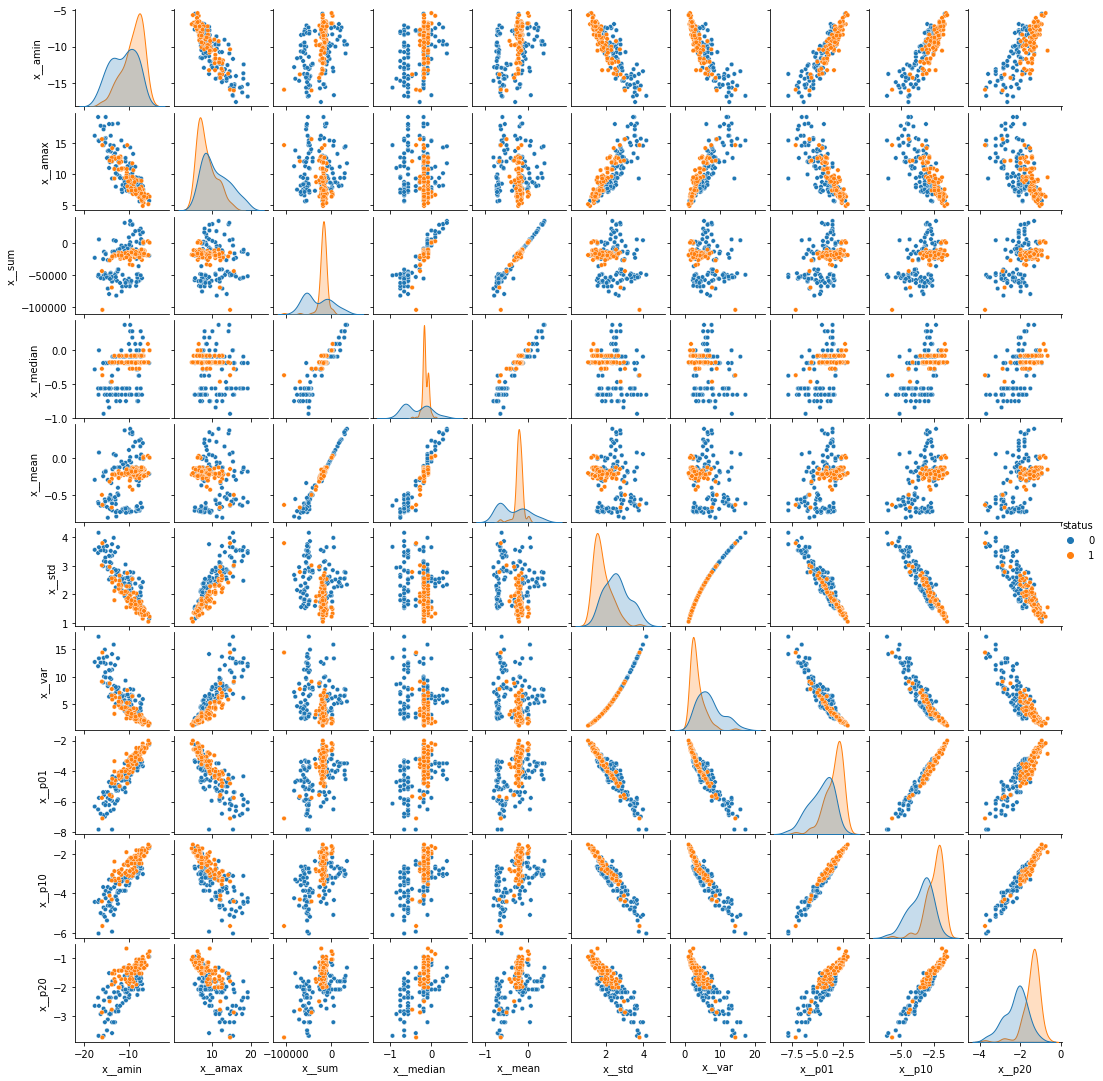

In [11]:
_ = sns.pairplot(data=df_plt, vars = cols[:10], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

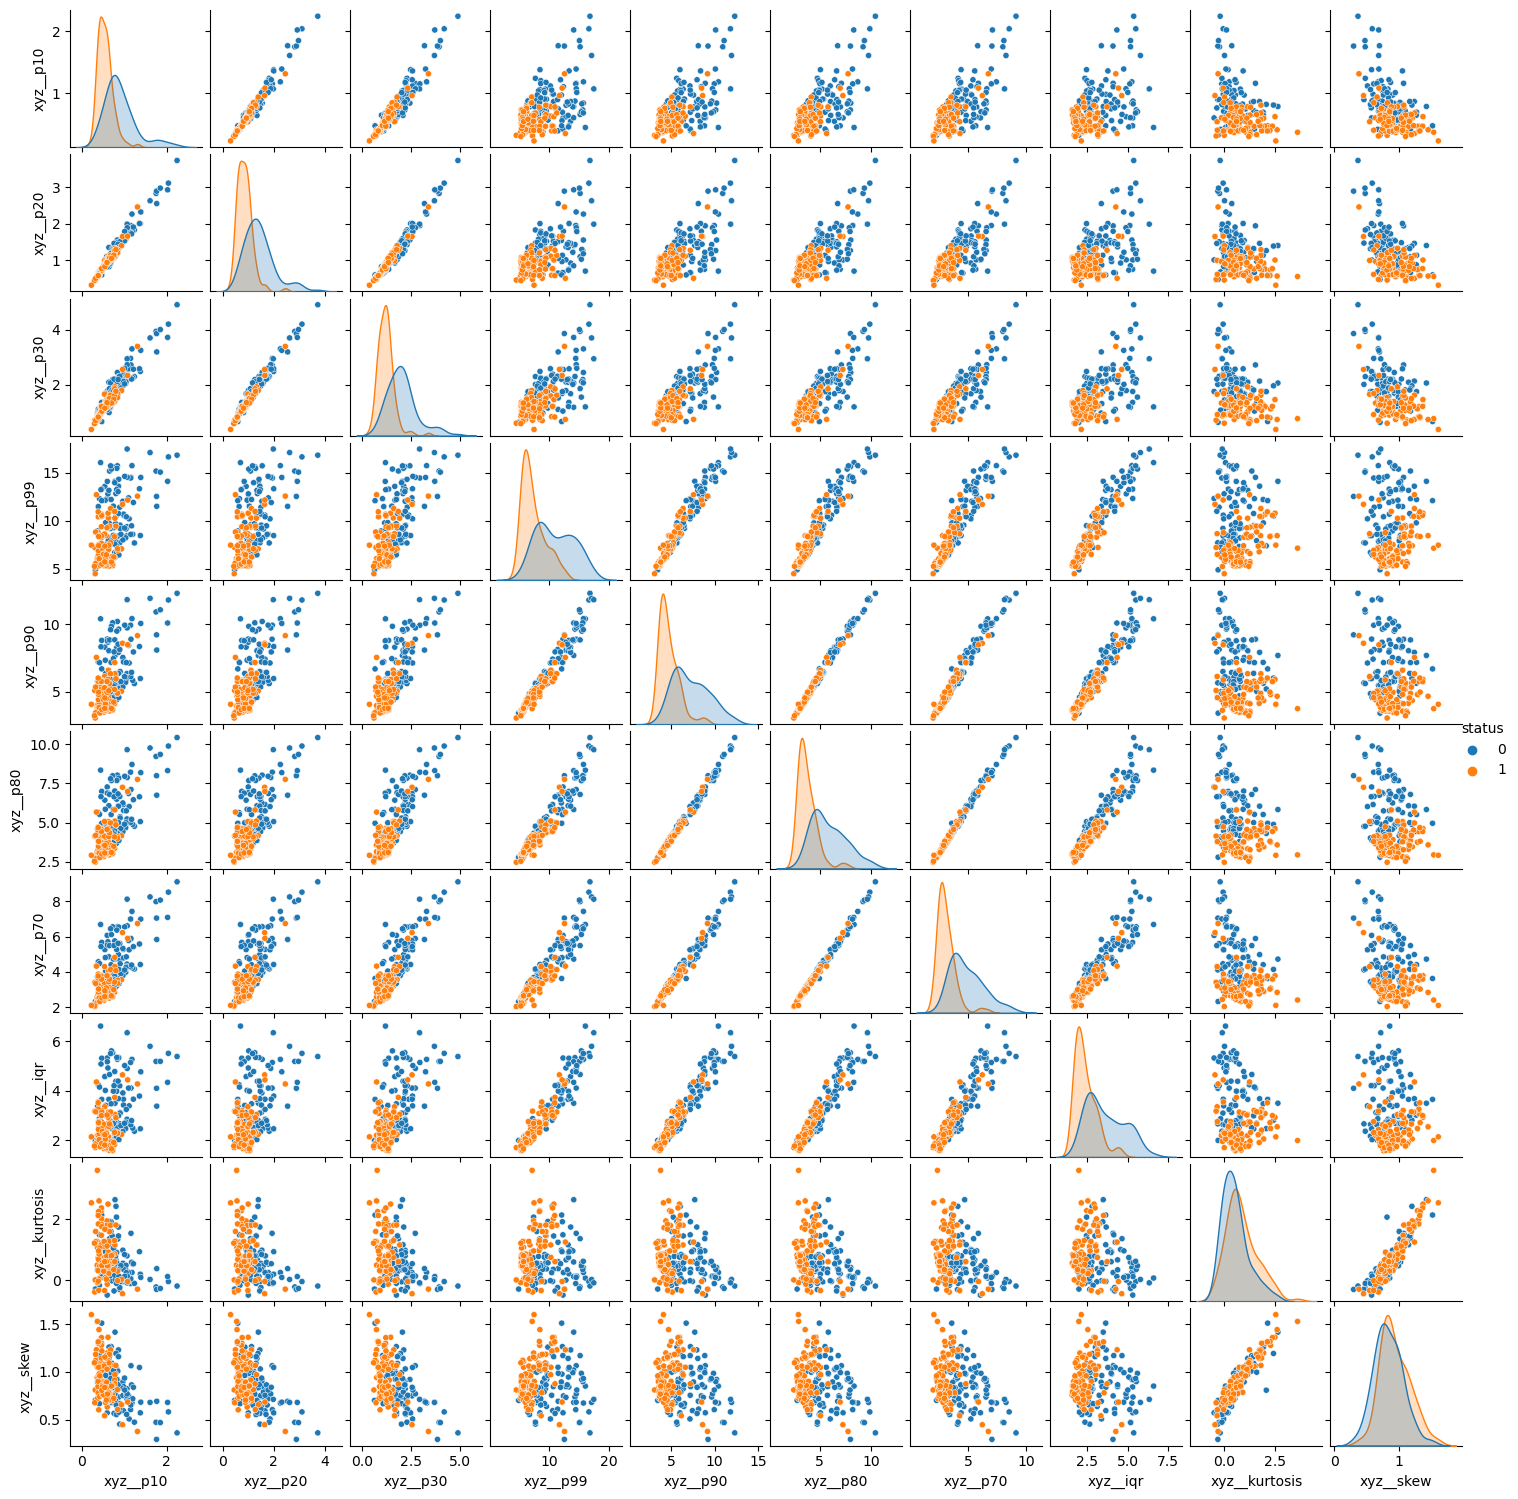

In [12]:
_ = sns.pairplot(data=df_plt, vars = cols[-10:], hue='status', plot_kws={'s': 20}).fig.set_size_inches(15,15)

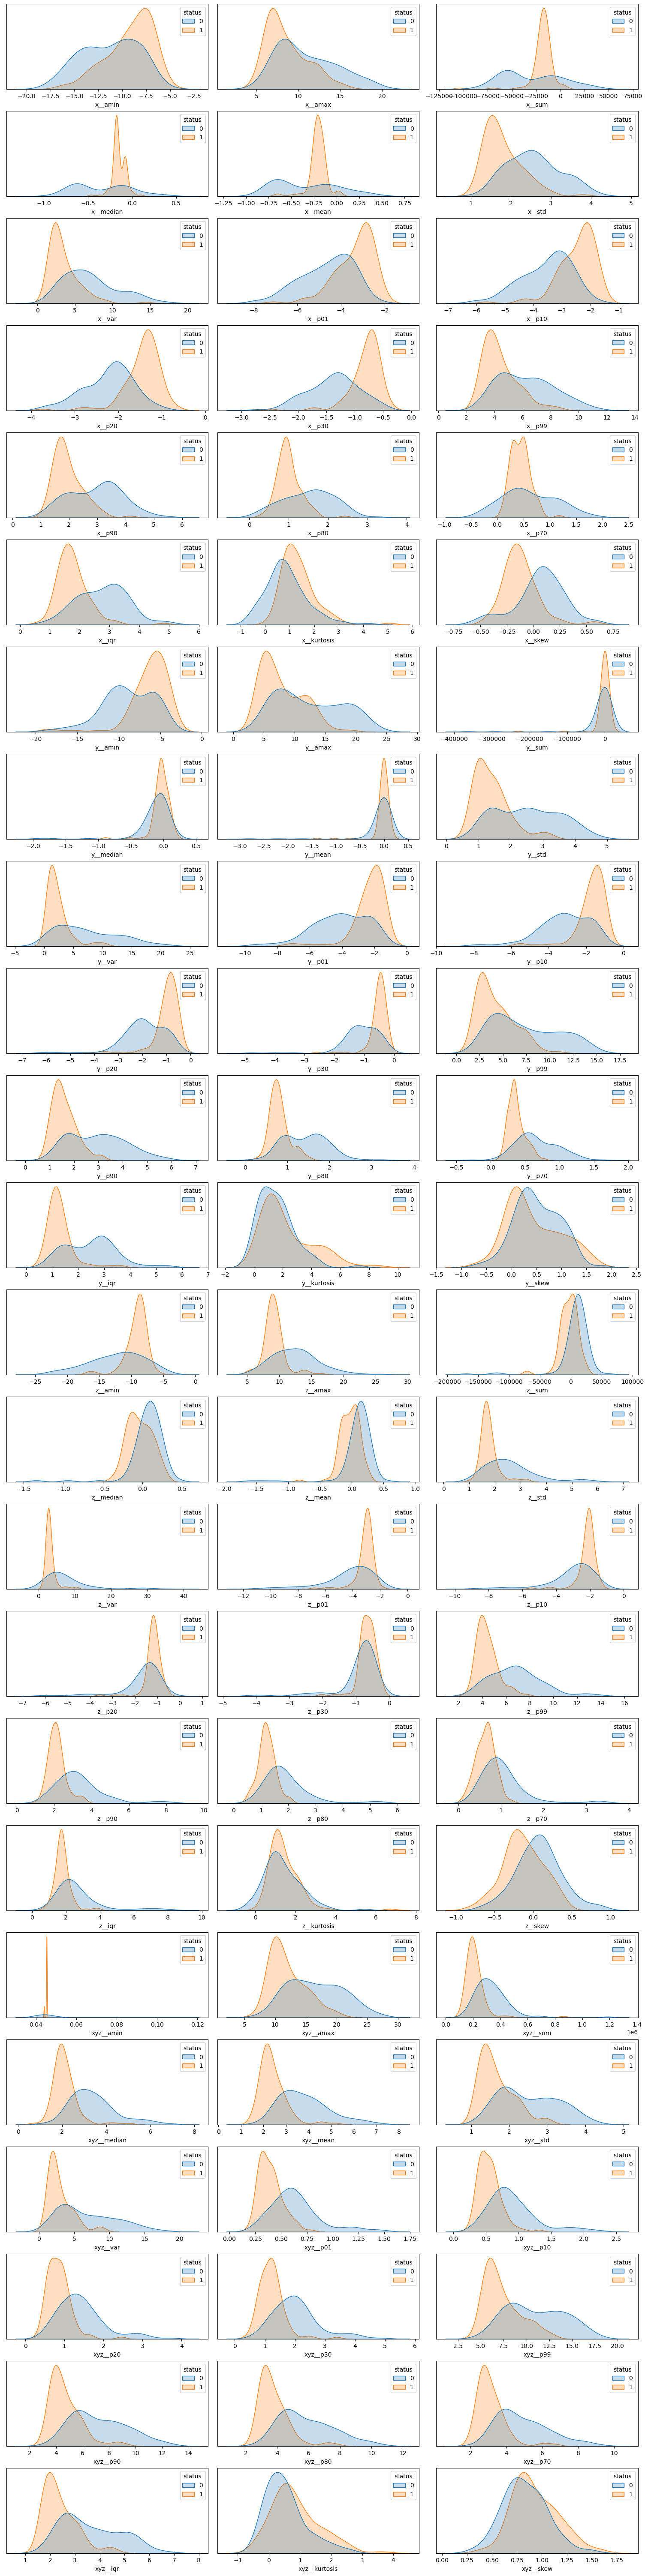

In [13]:
df_plt = df_train
# cols = ['x__amin', 'x__amax', 'x__sum','y__amin', 'y__amax', 'y__sum', 'z__amin', 'z__amax', 'z__sum']
cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

axs = t.get_axes(int(len(cols)/3), 3, 1/2)

for col, ax in zip(cols, axs.flat):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', shade=True)
    # _ = ax.axes.get_xaxis().set_visible(False)
    _ = ax.axes.get_yaxis().set_visible(False)
    # _ = ax.legend().set_visible(False)

In [14]:
df_train.columns
feature_cols = [col for col in df_plt.columns if not (col in ['experiment_id', 'bearing_id', 'status'])]

X = df_train[feature_cols]
X.shape
X.head(3)

y = df_train['status']
y.shape
y.head(3)

Index(['experiment_id', 'bearing_id', 'status', 'x__amin', 'x__amax', 'x__sum',
       'x__median', 'x__mean', 'x__std', 'x__var', 'x__p01', 'x__p10',
       'x__p20', 'x__p30', 'x__p99', 'x__p90', 'x__p80', 'x__p70', 'x__iqr',
       'x__kurtosis', 'x__skew', 'y__amin', 'y__amax', 'y__sum', 'y__median',
       'y__mean', 'y__std', 'y__var', 'y__p01', 'y__p10', 'y__p20', 'y__p30',
       'y__p99', 'y__p90', 'y__p80', 'y__p70', 'y__iqr', 'y__kurtosis',
       'y__skew', 'z__amin', 'z__amax', 'z__sum', 'z__median', 'z__mean',
       'z__std', 'z__var', 'z__p01', 'z__p10', 'z__p20', 'z__p30', 'z__p99',
       'z__p90', 'z__p80', 'z__p70', 'z__iqr', 'z__kurtosis', 'z__skew',
       'xyz__amin', 'xyz__amax', 'xyz__sum', 'xyz__median', 'xyz__mean',
       'xyz__std', 'xyz__var', 'xyz__p01', 'xyz__p10', 'xyz__p20', 'xyz__p30',
       'xyz__p99', 'xyz__p90', 'xyz__p80', 'xyz__p70', 'xyz__iqr',
       'xyz__kurtosis', 'xyz__skew'],
      dtype='object')

(200, 72)

,x__amin,x__amax,x__sum,x__median,x__mean,x__std,x__var,x__p01,x__p10,x__p20,x__p30,x__p99,x__p90,x__p80,x__p70,x__iqr,x__kurtosis,x__skew,y__amin,y__amax,y__sum,y__median,y__mean,y__std,y__var,y__p01,y__p10,y__p20,y__p30,y__p99,y__p90,y__p80,y__p70,y__iqr,y__kurtosis,y__skew,z__amin,z__amax,z__sum,z__median,z__mean,z__std,z__var,z__p01,z__p10,z__p20,z__p30,z__p99,z__p90,z__p80,z__p70,z__iqr,z__kurtosis,z__skew,xyz__amin,xyz__amax,xyz__sum,xyz__median,xyz__mean,xyz__std,xyz__var,xyz__p01,xyz__p10,xyz__p20,xyz__p30,xyz__p99,xyz__p90,xyz__p80,xyz__p70,xyz__iqr,xyz__kurtosis,xyz__skew
0,-9.060034,13.219381,13551.537240,-0.091625,0.160666,2.764551,7.642740,-3.962202,-3.112563,-2.074116,-1.224477,8.027145,3.873355,2.174078,1.135631,3.209746,0.767489,0.572186,-10.377857,19.224603,-2277.682122,-0.286109,-0.027004,3.402086,11.574188,-4.803368,-3.650025,-2.304459,-1.535564,12.400659,3.654478,1.636128,0.771121,3.075580,3.572725,1.246687,-11.303914,10.119949,9327.629252,0.155361,0.110588,2.074384,4.303071,-3.431890,-2.335786,-1.140035,-0.641806,5.436593,2.646508,1.550404,0.852882,2.092563,1.693552,-0.193308,0.044074,20.677288,327658.552507,3.282838,3.884696,2.909937,8.467731,0.529551,0.787399,1.397161,2.069899,14.116562,7.696333,5.830864,4.723116,3.498859,2.648418,1.415031
1,-15.573931,17.656383,-13476.085486,-0.186030,-0.190227,3.165250,10.018808,-5.567075,-4.056606,-2.451733,-1.507690,7.366315,3.684547,2.174078,1.135631,3.587363,1.250459,-0.119194,-11.819535,20.281834,-3071.643388,-0.189997,-0.043359,3.870017,14.977031,-6.148934,-4.418920,-2.785018,-1.631676,12.592883,4.615597,2.116688,0.963345,3.556140,2.342860,0.798273,-10.805685,12.411804,10970.236108,0.055715,0.154855,2.616524,6.846197,-4.129411,-3.033307,-1.737910,-1.040389,7.130573,3.443675,2.048633,1.151820,2.889730,0.763280,0.201409,0.044074,21.508638,334068.898797,4.201766,4.715690,3.109025,9.666039,0.772960,1.162456,1.936508,2.724092,14.530512,8.905194,7.107516,5.889537,4.109874,1.542872,1.064928
2,-13.685845,18.034001,-13477.835677,-0.091625,-0.147170,2.477668,6.138839,-4.339819,-3.112563,-1.790903,-0.846860,6.611080,2.834908,1.418843,0.474800,2.076895,2.329163,0.035625,-11.819535,18.936267,-2478.597665,0.002226,-0.027065,2.698046,7.279453,-4.322808,-3.073354,-1.727788,-0.766669,7.979513,3.173918,1.443905,0.482786,2.114461,3.992870,0.576046,-14.093999,12.710742,9927.077004,0.055715,0.108398,2.398597,5.753270,-3.830474,-2.634723,-1.339327,-0.542160,7.030927,3.045092,1.450758,0.653591,1.893272,2.373742,0.136053,0.044074,22.153908,308585.493767,2.888288,3.369573,2.802063,7.851557,0.300406,0.394059,0.643070,1.119238,11.474251,7.229530,5.635380,4.571681,4.241476,1.247548,1.049181


(200,)

0    0
1    0
2    0
Name: status, dtype: int64

In [15]:
t.to_pkl((X, y), f'{processed_data_path}/all_b1_b2_xyz_distance.data.pkl', True)